In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
test.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [45]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    display(max_cycle.head())
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

unit_nr
1    192
2    287
3    179
4    189
5    269
Name: time_cycles, dtype: int64

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [6]:
drop_labels = index_names+setting_names
#dropping the columns except the sensor datas
X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

In [7]:
# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, the test set is subsetted to represent the same.
# Reducing from 13095 rows to 100 rows
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [8]:
X_train.shape

(20631, 21)

In [9]:
from sklearn.model_selection import train_test_split

X_trains, X_val, y_trains, y_val = train_test_split(X_train, y_train, test_size=0.2)

Normal Model

In [10]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [11]:
model = keras.Sequential()
model.add(Dense(21, activation='relu', input_shape=(21,)))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [12]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [13]:
optimizer_A=tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer_A,loss='mean_absolute_error',metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 21)                462       
                                                                 
 batch_normalization (BatchN  (None, 21)               84        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                704       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1024)              33792     
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                        

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-7, verbose=1)

In [16]:
history = model.fit(x=X_train,y=y_train,
                    validation_data = (X_val,y_val),
                    epochs = 50,
                    shuffle = True,
                    callbacks=[reduce_lr])

Epoch 1/50
645/645 [==============================] - 5s 7ms/step - loss: 40.1100 - accuracy: 0.0048 - val_loss: 1648.4702 - val_accuracy: 0.0046 - lr: 0.0010
Epoch 2/50
645/645 [==============================] - 4s 6ms/step - loss: 33.8242 - accuracy: 0.0048 - val_loss: 2188.2520 - val_accuracy: 0.0046 - lr: 0.0010
Epoch 3/50
645/645 [==============================] - 4s 6ms/step - loss: 32.8677 - accuracy: 0.0048 - val_loss: 71.3101 - val_accuracy: 0.0046 - lr: 0.0010
Epoch 4/50
645/645 [==============================] - 4s 6ms/step - loss: 32.3728 - accuracy: 0.0048 - val_loss: 104.2253 - val_accuracy: 0.0046 - lr: 0.0010
Epoch 5/50
645/645 [==============================] - 4s 6ms/step - loss: 32.1122 - accuracy: 0.0048 - val_loss: 69.3763 - val_accuracy: 0.0046 - lr: 0.0010
Epoch 6/50
645/645 [==============================] - 4s 6ms/step - loss: 32.0529 - accuracy: 0.0048 - val_loss: 106.6724 - val_accuracy: 0.0046 - lr: 0.0010
Epoch 7/50
645/645 [==============================] 

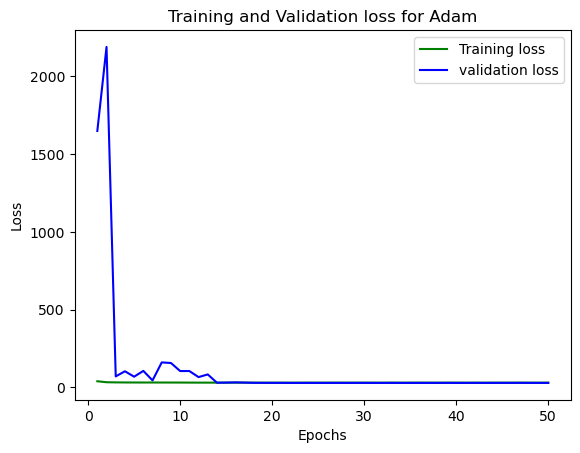

In [17]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for Adam')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

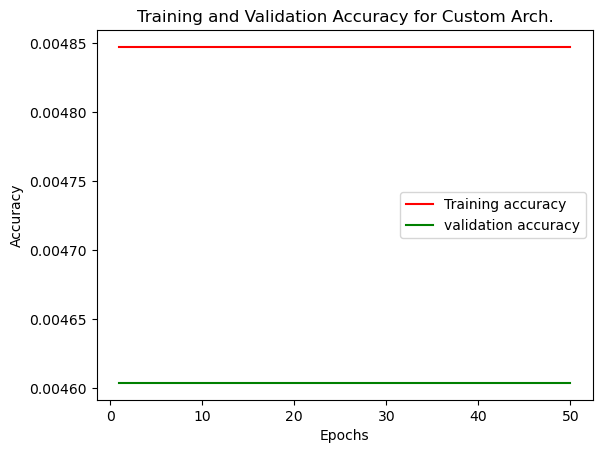

In [18]:
import matplotlib.pyplot as plt
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, acc_train, 'r', label='Training accuracy')
plt.plot(epochs, acc_val, 'g', label='validation accuracy')
plt.title('Training and Validation Accuracy for Custom Arch.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
y_pred = model.predict(X_test)
print(y_pred.shape)

4/4 [==============================] - 0s 5ms/step
(100, 1)


In [20]:
import sklearn

print(sklearn.metrics.r2_score(y_test, y_pred))
#print(sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred))
print(sklearn.metrics.mean_absolute_error(y_test, y_pred))

0.5829742550849915
20.160185079574585


Neural Architecture using AutoKeras

In [21]:
!pip install autokeras

In [22]:
from autokeras import StructuredDataRegressor

ModuleNotFoundError: No module named 'autokeras'

In [ ]:
search = StructuredDataRegressor(max_trials=15, loss='mean_absolute_error') #no of trial and errors allowed
search.fit(x=X_train, y=y_train, verbose=1) #fitting the model

In [ ]:
mae, acc = search.evaluate(X_test, y_test, verbose=1)

In [ ]:
yhat = search.predict(X_test)

In [ ]:
print(sklearn.metrics.r2_score(y_test, yhat))
#print(sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred))
print(sklearn.metrics.mean_absolute_error(y_test, yhat))

In [ ]:
model1 = search.export_model()

In [ ]:
model1.summary()

In [ ]:
model1.save('model1.tf') #saving the model